# fMRI Data Analysis: Group-Level Analysis


---------------

In [60]:
import os

import os.path as op # for file path operations
import glob # to search for files using regex

import pandas as pd # for data manipulation
import numpy as np # for numerical operations

from bids.layout import BIDSLayout # to fetch data from BIDS-compliant datasets

import matplotlib.pyplot as plt # for basic plotting

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.plotting import plot_glass_brain, plot_design_matrix, plot_contrast_matrix, plot_stat_map, view_img, view_img_on_surf
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.datasets import load_mni152_template
from nilearn.glm.second_level import non_parametric_inference

from atlasreader import create_output # For generating result tables https://github.com/miykael/atlasreader

import math

In [61]:
# MNI152 template will be used as a backgound for plotting
mni152_template = load_mni152_template()

## Retrieve First-Level results

In [62]:
# --- Set up the paths to the data and results folders
fmri_data_dir = '/imaging/correia/da05/students/mohith/Gagnepain2017JoN/data' # data in BIDS format
fmri_results_dir = '/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results' # results in BIDS format

# --- Set up the BIDS layout
layout = BIDSLayout(fmri_data_dir, derivatives = True)

# Attach the results folder to the layout. It must complay with BIDS standards. 
# And must include dataset_description.json file!
layout.add_derivatives(op.join(fmri_results_dir, "first-level_duration-0"))

Specify which conditions to include in the analysis and retrieve their effect files from the first-level results.

In [63]:
conditions = ['negT', 'negNTi', 'negNTni', 'neutrT', 'neutrNTi', 'neutrNTni']

effect_files = layout.get(desc=conditions, suffix='effect', extension='.nii.gz', return_type='filename')

# print to see if it found what we expexted
print(f"Found {len(effect_files)} effect files:")
print(*effect_files, sep="\n")

Found 144 effect files:
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-100/sub-100_task-tnt_desc-negNTi_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-100/sub-100_task-tnt_desc-negNTni_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-100/sub-100_task-tnt_desc-negT_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-100/sub-100_task-tnt_desc-neutrNTi_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-100/sub-100_task-tnt_desc-neutrNTni_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-100/sub-100_task-tnt_desc-neutrT_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-105/sub-105_task-tnt_desc-negNTi_effect.nii.gz
/imaging/corr

## Displaying subject Think vs No-Think z-maps

In [64]:
eoi_maps = layout.get(desc='ThinkNoThink', extension='.nii.gz', return_type='file')
print(*eoi_maps, sep="\n")

/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-100/sub-100_task-tnt_desc-ThinkNoThink_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-105/sub-105_task-tnt_desc-ThinkNoThink_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-110/sub-110_task-tnt_desc-ThinkNoThink_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-115/sub-115_task-tnt_desc-ThinkNoThink_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-120/sub-120_task-tnt_desc-ThinkNoThink_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-125/sub-125_task-tnt_desc-ThinkNoThink_effect.nii.gz
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/first-level_duration-0/sub-130/sub-130_task-tnt_desc-ThinkNoThink_effect.nii.gz

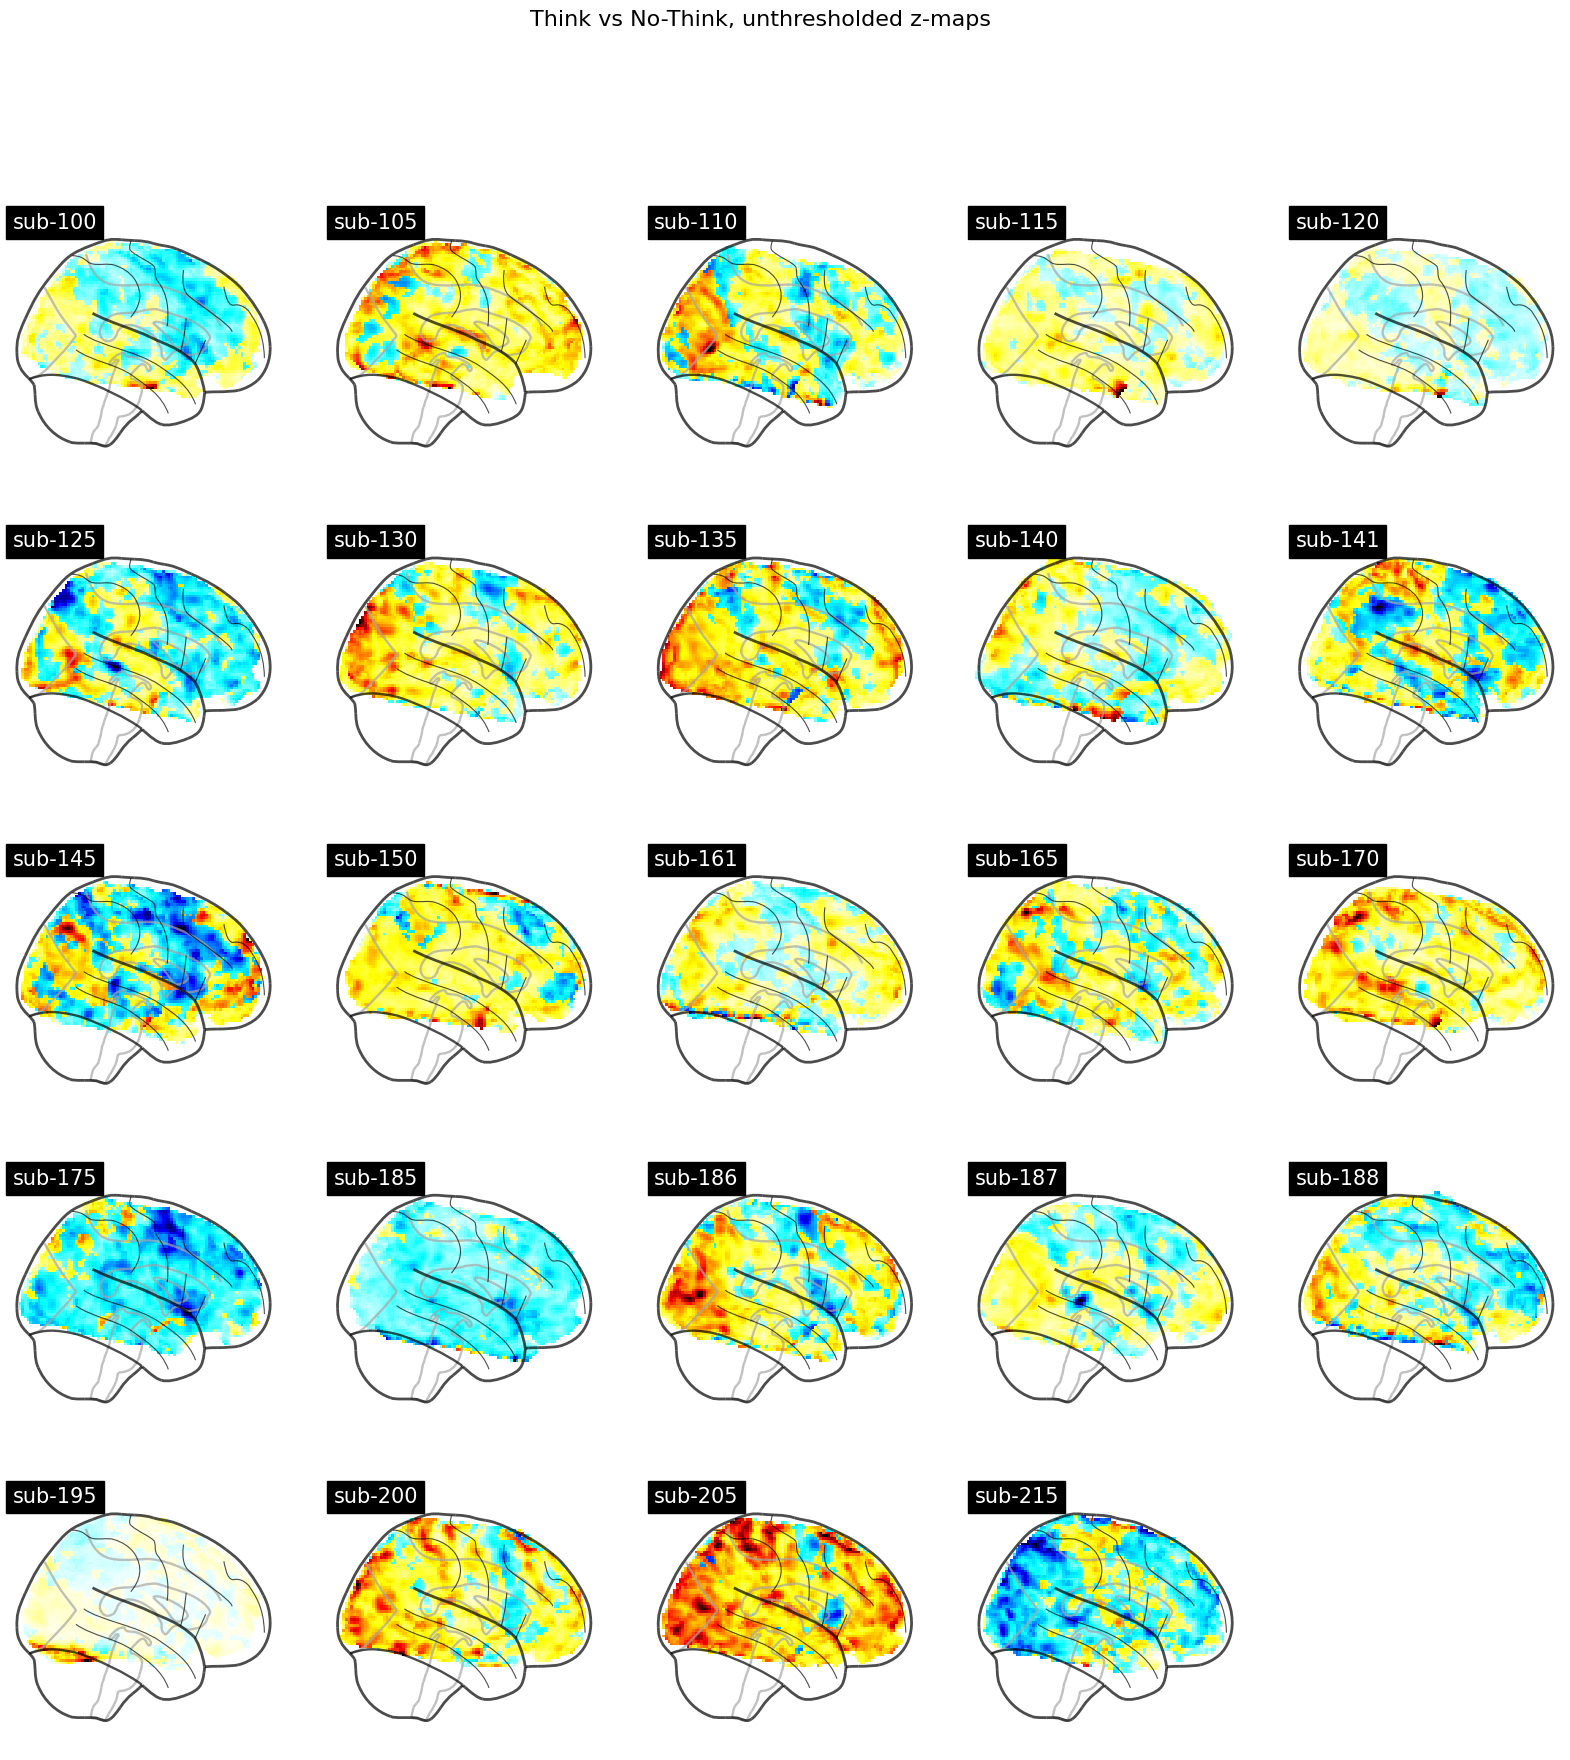

In [65]:
subjects = layout.get_subjects()

# Calculate number of subjects
n_subjects = len(subjects)

# Calculate number of rows and columns needed
cols = int(math.ceil(math.sqrt(n_subjects)))  # Use a square-like layout
rows = int(math.ceil(n_subjects / cols))  # Number of rows required

# Create subplots with dynamic size
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4 * cols, 4 * rows))  # Size scales with grid size

# Flatten axes to make it easier to loop, in case there are more subplots than subjects
axes = axes.flatten()

# Plot each subject's stat_map
for i, stat_map in enumerate(eoi_maps):
    plot_glass_brain(stat_map, 
                     title=f'sub-{subjects[i]}',
                     axes=axes[i],
                     plot_abs=False, 
                     display_mode='x')

# Hide any unused axes if the number of subjects is smaller than the number of axes
for ax in axes[len(eoi_maps):]:
    ax.axis('off')

# Add a main title for the entire figure
fig.suptitle('Think vs No-Think, unthresholded z-maps', fontsize=16)

# Show the plot
plt.show()

## Specify the second-level model

In [66]:
conditions = ['negT', 'negNTi', 'negNTni', 'neutrT', 'neutrNTi', 'neutrNTni']

# Create an empty DataFrame
df = pd.DataFrame(columns=conditions + subjects)

# Populate the DataFrame with 0s and 1s
for i, condition in enumerate(conditions):
    # Filter files based on condition
    condition_files = [1 if condition in file else 0 for file in effect_files]
    # Add a column for the condition
    df[condition] = condition_files

# Populate the DataFrame with 0s and 1s for subjects
for i, subject in enumerate(subjects):
    # Filter files based on subject
    subject_files = [1 if f"sub-{subject}" in file else 0 for file in effect_files]
    # Add a column for the subject
    df[subject] = subject_files

# Print the resulting DataFrame
design_matrix = df
design_matrix

,negT,negNTi,negNTni,neutrT,neutrNTi,neutrNTni,100,105,110,115,...,170,175,185,186,187,188,195,200,205,215
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
140,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
141,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
142,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Text(57.097222222222214, 0.5, 'stat maps')

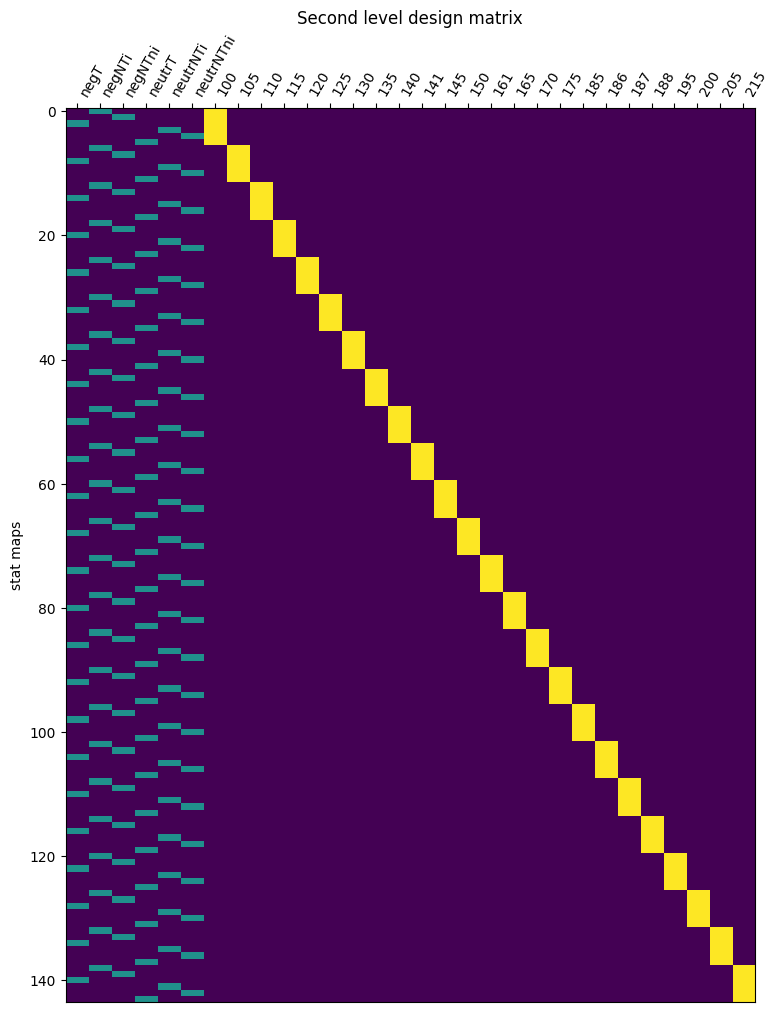

In [67]:
ax = plot_design_matrix(design_matrix)
ax.set_title("Second level design matrix", fontsize=12)
ax.set_ylabel("stat maps")

### Contrasts

In [68]:
n_columns = design_matrix.shape[1]

# Automatically compute the padding amount to avoid negative values
contrast_vectors = {
    'NoThink_Think': [-1/2, 1/4, 1/4, -1/2, 1/4, 1/4]
}

# Dynamically pad the contrast vector
contrasts = {}
for name, vector in contrast_vectors.items():
    padding = max(0, n_columns - len(vector))  # Ensure non-negative padding
    contrasts[name] = np.pad(vector, (0, padding), 'constant')

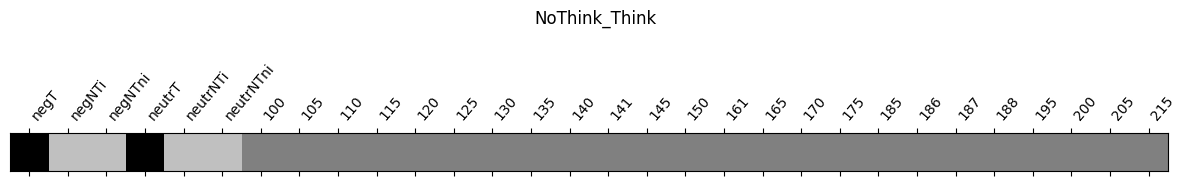

In [69]:
for contrast_id, contrast_val in contrasts.items():
    plot_contrast_matrix(contrast_val, design_matrix=design_matrix)
    plt.suptitle(contrast_id)

### Model specification and fit

In [70]:
# specify
second_level_model = SecondLevelModel() 
# fit
second_level_model = second_level_model.fit(
  effect_files, 
  design_matrix = design_matrix
  )

## Computing contrasts and plotting result maps

In [71]:
# get the z-maps for the contrast
z_map = second_level_model.compute_contrast(
  contrasts['NoThink_Think'], 
  output_type='z_score')

### False-positive-rate with cluster-forming threshold

In [72]:
thresholded_map_fpr, threshold_fpr = threshold_stats_img(
  z_map, 
  alpha=0.001, 
  height_control='fpr', 
  cluster_threshold=20,
  two_sided=True)


In [73]:
# Interactive plotting
plot = view_img(
  thresholded_map_fpr, 
  bg_img=mni152_template, 
  threshold=threshold_fpr, 
  colorbar=True, 
  title='No-Think > Think  (p < .001, uncorrected)'
  )

plot.open_in_browser()

/imaging/correia/da05/conda/env/mri/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [74]:
# save z-map
out_dir = op.join(fmri_results_dir, 'group-level_duration-0')
if not op.exists(out_dir):
    os.makedirs(out_dir)
z_map.to_filename(op.join(out_dir, 'NoThink_Think_zmap.nii.gz'))

### FWE correction using non-parametric permutation testing

In [75]:
out_dict = non_parametric_inference(
    effect_files,
    design_matrix = design_matrix,
    second_level_contrast = contrasts['NoThink_Think'],
    n_perm = 10000, # ideally at least 10000
    two_sided_test = True,
    n_jobs = -1, # Use all available cores
    threshold = 0.001 # cluster level threshold; enables cluster-level inference
)

# Print the keys of the output dictionary
print(out_dict.keys())

/imaging/correia/da05/conda/env/mri/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/imaging/correia/da05/conda/env/mri/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


dict_keys(['t', 'logp_max_t', 'size', 'logp_max_size', 'mass', 'logp_max_mass'])


In [76]:
alpha = 0.05
masked = out_dict['logp_max_t'].get_fdata() > -np.log10(alpha)
masked_t_map = out_dict['t'].get_fdata() * masked

# save the masked t-map as a nifti image
masked_t_map_img = nib.Nifti1Image(masked_t_map, out_dict['t'].affine)

In [83]:
# Save the unthresholded t-map
out_dir = op.join(fmri_results_dir, 'group-level_duration-0')
if not op.exists(out_dir):
    os.makedirs(out_dir)
out_dict['t'].to_filename(op.join(out_dir, 'NoThink_Think_tmap.nii.gz'))

FWE (perm.) p<.05 threshold: 4.957


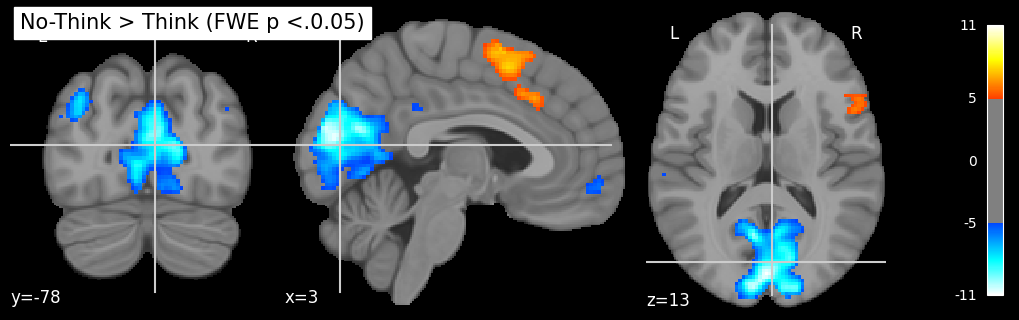

In [77]:
# Get the smallest t-value that is above the threshold (for the colorbar; the maps themselves are thresholded already)
threshold_fwe = masked_t_map[masked_t_map > 0].min()
print('FWE (perm.) p<.05 threshold: %.3f' % threshold_fwe)

plot_stat_map(
    masked_t_map_img, 
    threshold = threshold_fwe,       
    display_mode = 'ortho',
    black_bg = True,
    bg_img = mni152_template,
    title = f"No-Think > Think (FWE p <.{alpha})")

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

In [78]:
# Interactive plotting
plot = view_img(
  masked_t_map_img, 
  bg_img=mni152_template, 
  threshold=threshold_fwe, 
  colorbar=True, 
  title = f"No-Think > Think (FWE p <.{alpha})"
  )

plot.open_in_browser()

/imaging/correia/da05/conda/env/mri/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Summary results


In [79]:
# generate and save atlasreader output
outdir = op.join(fmri_results_dir, 'group-level_duration-0', 'permutation', 'NoThinkThink')

create_output(
    masked_t_map_img, 
    cluster_extent = 20, 
    voxel_thresh = threshold_fwe,
    direction = 'pos',
    outdir = outdir
)

In [80]:
# display the peak table
peaks = glob.glob(op.join(outdir, '*_peaks.csv'))
display(pd.read_csv(peaks[0]))

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,50.0,12.0,6.0,10.303331,7320.0,Frontal_Inf_Oper_R,ctx-rh-parsopercularis,38.0% Right_Inferior_Frontal_Gyrus_pars_opercu...
1,2.0,16.0,14.0,62.0,10.166979,7104.0,Supp_Motor_Area_R,ctx-rh-superiorfrontal,64.0% Right_Superior_Frontal_Gyrus
2,3.0,54.0,-44.0,36.0,7.724744,2888.0,SupraMarginal_R,Unknown,38.0% Right_Supramarginal_Gyrus_posterior_divi...
3,4.0,-46.0,16.0,2.0,6.093250,368.0,Frontal_Inf_Tri_L,ctx-lh-parsopercularis,36.0% Left_Frontal_Operculum_Cortex; 30.0% Lef...
4,5.0,18.0,14.0,8.0,6.074539,296.0,Caudate_R,Right-Cerebral-White-Matter,34.0% Right_Caudate
5,6.0,52.0,4.0,44.0,5.635879,272.0,Precentral_R,ctx-rh-precentral,65.0% Right_Precentral_Gyrus; 12.0% Right_Midd...


In [81]:
# display the cluster table
clusters = glob.glob(op.join(outdir, '*_clusters.csv'))
display(pd.read_csv(clusters[0]))

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,50.0,12.0,6.0,6.490930,7320.0,35.08% Frontal_Inf_Oper_R; 32.68% Insula_R; 25...,38.80% Unknown; 25.36% ctx-rh-parsopercularis;...,30.16% Right_Inferior_Frontal_Gyrus_pars_operc...
1,2.0,16.0,14.0,62.0,6.242819,7104.0,53.94% Supp_Motor_Area_R; 25.23% Cingulate_Mid...,42.45% ctx-rh-superiorfrontal; 29.95% Unknown;...,49.77% Right_Superior_Frontal_Gyrus; 26.80% Ri...
2,3.0,54.0,-44.0,36.0,6.153209,2888.0,75.35% SupraMarginal_R; 14.13% Angular_R; 10.5...,37.67% Unknown; 27.15% ctx-rh-inferiorparietal...,57.89% Right_Supramarginal_Gyrus_posterior_div...
3,4.0,-46.0,16.0,2.0,5.359520,368.0,58.70% Frontal_Inf_Tri_L; 32.61% Insula_L; 6.5...,50.00% ctx-lh-parsopercularis; 41.30% Unknown;...,67.39% Left_Frontal_Operculum_Cortex; 30.43% L...
4,5.0,18.0,14.0,8.0,5.372192,296.0,72.97% Caudate_R; 16.22% Putamen_R; 10.81% no_...,54.05% Right-Caudate; 27.03% Right-Cerebral-Wh...,75.68% Right_Caudate; 24.32% Right_Putamen
5,6.0,52.0,4.0,44.0,5.205708,272.0,85.29% Precentral_R; 14.71% Frontal_Mid_2_R,38.24% ctx-rh-precentral; 29.41% Unknown; 17.6...,52.94% Right_Precentral_Gyrus; 47.06% Right_Mi...
